In [1]:
'''
This notebook implements a batch run for OFAT analysis
Packages
'''
from model import *
import csv
from mesa.batchrunner import BatchRunner
import pandas as pd
import numpy as np
import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from joblib import Parallel, delayed, cpu_count

In [7]:
def collect_samples(samples, columns, parameter, values):
    df_experiment = pd.DataFrame(columns=columns)
    parameter_name = parameter
    kwargs = {f'{parameter}':values}
    for k in range(int(samples)):
        '''
        Repeat trial with certain parameter k times to apply clt
        '''            
        model = HousingMarket(**kwargs)
        model.run_model(max_steps)
        data = model.datacollector.get_model_vars_dataframe()
        dic = {'Variable': parameter_name, 'Parameter': values, 'Gini': data['Gini'].iloc[-1]}
        df_experiment = pd.concat([df_experiment, pd.DataFrame(pd.Series(dic)).T])
    return df_experiment

def run_batch_parallel(problem, i, ofat_size, samples, columns):
    parameter = problem['names'][i]
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    results = Parallel(n_jobs= 10)(delayed(collect_samples)(samples, columns, parameter, value)
                       for value in variable_values)
    final = pd.concat(results)
    return final

def run_batch_parallel_plotter(result, i):
    '''
    This plots the result from running a batch runner in parallel
    '''
    
    fig = plt.plot( figsize = (20,40))
    y = []
    err = []
    x = np.linspace(*problem['bounds'][i], ofat_size)

    for j in range(len(x)):
        series = result['Gini'][int(j*samples):int((j+1)*samples)]
        y.append(series.mean())
        err.append(1.96 * (series.std()/np.sqrt(samples)))

    plt.plot(x, y , c='k')
    plt.fill_between(x, np.array(y) - np.array(err), np.array(y) + np.array(err)) 
    plt.ylabel("Gini")
    plt.xlabel(problem['names'][i])
    plt.show()

In [5]:
'''
This defines the bounds of for the ofat analysis
'''
problem = {
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 
              'payoff_perc_freehold', 'inflation', 'chi_parameter', 'bank_income_multiplier', 
             'alpha_mean', 'beta_mean', 'lmbda_mean'],
    'bounds': [[1, 40_000], [1, 100_000], [10_000, 90_000], [11_000, 100_000],
              [0.001,0.1],[0.01,0.03],[5,7.5],[0,20],
              [0.01, 2.5], [0.01, 2.5], [0.01, 2.5]]    
}

columns = ('Variable', 'Parameter', 'Gini')

'''
This defines model run
'''
samples = 30
max_steps = 10000
ofat_size = 12

In [ ]:
'''
alpha
'''
sa_savingslower = run_batch_parallel(problem, 8, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_savingslower, 8)
#sa_savingslower.to_csv('C:/Users/sebas/Documents/GitHub/ABM/outputs/sa_savingslower.csv')

In [ ]:
'''
beta
'''
sa_savingslower = run_batch_parallel(problem, 9, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_savingslower, 9)
#sa_savingslower.to_csv('C:/Users/sebas/Documents/GitHub/ABM/outputs/sa_savingslower.csv')

In [ ]:
'''
lambda
'''
sa_savingslower = run_batch_parallel(problem, 10, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_savingslower, 10)
#sa_savingslower.to_csv('C:/Users/sebas/Documents/GitHub/ABM/outputs/sa_savingslower.csv')

In [ ]:
'''
Savings Lower
'''
sa_savingslower = run_batch_parallel(problem, 0, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_savingslower, 0)
sa_savingslower.to_csv('C:/Users/sebas/Documents/GitHub/ABM/outputs/sa_savingslower.csv')

In [ ]:
'''
Savings upper
'''
sa_savingsupper = run_batch_parallel(problem, 1, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_savingsupper, 1)
sa_savingsupper.to_csv('outputs/sa_savingsupper.csv')

In [ ]:
'''
Price lower
'''
sa_pricelower = run_batch_parallel(problem, 2, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_pricelower, 2)
sa_pricelower.to_csv('outputs/sa_pricelower.csv')

In [ ]:
'''
Price upper
'''
sa_priceupper = run_batch_parallel(problem, 3, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_priceupper, 3)
sa_priceupper.to_csv('outputs/sa_priceupper.csv')

In [ ]:
'''
payoff_perc_freehold
'''
sa_payoff = run_batch_parallel(problem, 4, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_payoff, 4)
sa_payoff.to_csv('outputs/sa_payoff.csv')

In [ ]:
'''
Inflation
'''
sa_inflation = run_batch_parallel(problem, 5, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_inflation, 5)
sa_inflation.to_csv('outputs/sa_inflation.csv')

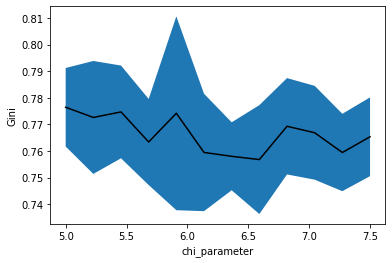

In [6]:
'''
Chi parameter
'''
sa_chi = run_batch_parallel(problem, 6, ofat_size, samples, columns)
run_batch_parallel_plotter(sa_chi, 6)
sa_chi.to_csv('outputs/sa_chi.csv')

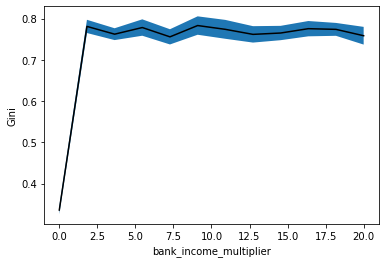

In [8]:
results = run_batch_parallel(problem, 7, ofat_size, samples, columns)
run_batch_parallel_plotter(results, 7)

In [ ]:
results.to_csv('outputs/sa_bankincome')

In [2]:
def run_model(steps, kwargs):
    model = HousingMarket(**kwargs)
    model.run_model(steps)
    data = model.datacollector.get_model_vars_dataframe()
    return data['Gini'].iloc[-1]

In [3]:
kwargs = {'alpha_mean':20, 'beta_mean':20, 'lmbda_mean':2, 'savings_upper': 0, 'inflation': 0.3, 'payoff_perc_freehold':0.1,
         'age_utility_scaling': 0}

In [ ]:
results = Parallel(n_jobs= cpu_count())(delayed(run_model)(steps=30000, kwargs = {})
                       for i in range(24))

np.mean(results)

In [ ]:
import csv
row=['Gini']

with open('outputs/banking_experiment_group0.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerows([results])

In [ ]:
import matplotlib.pyplot as plt
plt.hist(results)
plt.title("Standard model")
plt.savefig("outputs/banking_hist_group0.png", dpi=300)

In [ ]:
results1 = []
with open('outputs/banking_experiment_group1.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        results1.append(row)

In [ ]:
plt.hist(list(np.array(results1[0]).astype(float)))
plt.title("More mortgage for long-time renters")
plt.savefig("outputs/banking_hist_group1.png", dpi=300)

## Global Sensitivy Analysis

In [ ]:
# YOUR NAME HERE
name = "extra"
assert name in ['Martina', "Nils", "Sebastiaan", "Alex", "Julius", "extra"], "please fill in a name of a group member"

In [ ]:
def run_SOBOL(values, problem, max_steps, counter):
    # build kwargs
    kwargs = {}
    for i, name in enumerate(problem['names']):
        kwargs[name] = values[i]
    model = HousingMarket(**kwargs)
    model.run_model(max_steps)
    data = model.datacollector.get_model_vars_dataframe()
        
    # add run data to the dictionary
    kwargs['Run'] = counter
    kwargs['Gini'] = data['Gini'].iloc[-1]

    return pd.DataFrame(pd.Series(kwargs)).T

In [ ]:
replicates = 30
max_steps = 1000
distinct_samples = 64

In [ ]:
# read saltelli samples
param_values = pd.read_csv(f"saltelli_samples/param_values_{name}", index_col=0)

In [ ]:
import math
problem = {
    'num_vars': 8,
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 
              'payoff_perc_freehold', 'inflation', 'chi_parameter', 'bank_income_multiplier'],
    'bounds': [[1, 40_000], [50_000, 100_000], [10_000, 90_000], [100_000, 1_000_000],
              [0.001,0.0025],[0.01,0.03],[5,7.5],[6,9]]    
}
assert len(param_values) == math.floor(distinct_samples*(2*problem['num_vars']+2)/5), "The amount of samples is incorrect"

In [ ]:
from tqdm import notebook
results = Parallel(n_jobs=cpu_count())(delayed(run_SOBOL)(param_values.iloc[i%len(param_values),:], problem, max_steps, 
                                                i)
                       for i in notebook.tqdm(range(len(param_values)*replicates)))

df_global = pd.concat(results)
df_global.to_csv(f"sobol_results/results_{name}")